# Recommendation Using Factorization Machine

In this assignment, you will work on implementing the factorization machine for recommendation problems. You will implement factorization machine for both classification and regression.

We will be re-using the dataset from the previous homework: the Criteo data (https://www.kaggle.com/c/avazu-ctr-prediction) and using another dataset: the MovieLens 100K Dataset (https://grouplens.org/datasets/movielens/). Both of these datasets are included in your homework package.

Throughout the notebook you'll see TODO tags in the comments. This is where you should insert your own code to make the functions work! If you get stuck, we encourage you to come to office hours. You can also try to look at APIs and documentation online to try to get a sense how certain methods work. If you take inspiration from any source online other than official documentation, please be sure to cite the resource! Good luck!

**Small warning**: This homework may be time-consuming for those who are not strong in Python. If you feel you may spend too much time on this homework, complete as much as you can, as there are parts that are not intensive. Please budget your time carefully since we are near the end of the semester.

You will also see a new decorator for enabling Numba which is a just-in-time compiler for Python which can optimize numpy-based code. Unlike the last homework, we will not be using dense **numpy.array** to store the feature data **X**. Instead, it will be stored using **scipy.sparse.csr_matrix**. It is advised that the prototypes for each of the functions you implement are kept intact.

First we will start with mandatory imports.

In [265]:
# Mandatory imports
from IPython.display import Image
import math
import matplotlib.pyplot as plt
from numba import njit
import numpy
from numpy.lib import recfunctions as rfn
import os
import scipy
import scipy.sparse as sparse
import scipy.optimize as optimize
import scipy.special as special
from sklearn.preprocessing import OneHotEncoder
from tqdm import trange

# Supporting Test Functions for MovieLens and Criteo Datasets
There are two functions *test_movie_lens_data* and *test_criteo_data* which can be used to test and plot validation error cruves. For the Criteo dataset, we will be using it for classification. For the MovieLens dataset, it will be used for both classification and regression. There are couple of small sanity test routines at the end which will be used in a later part. **There is no need to modify any of the following functions.**

In [266]:
## Converts the X consisting of all categorical data into one-hot-encoding and splits
#  the X and Y data set into training/validation with the ratio of 4:1.
def preprocess_one_hot_encoding(labeled_data_X, labeled_data_Y):
    
    # Apply one-hot-encoding.
    enc = OneHotEncoder(handle_unknown='ignore')
    x = enc.fit_transform(labeled_data_X)

    # Divide the data into train/validation.
    validation_data_size = int(labeled_data_X.shape[0] / 5)
    validation_data_X = x[ 0 :validation_data_size, : ]
    training_data_X = x[ validation_data_size:, : ]
    validation_data_Y = labeled_data_Y[ 0 :validation_data_size]
    training_data_Y = labeled_data_Y[ validation_data_size: ]
    print('Divided into the training set of size ', training_data_X.shape[0])
    print('and the validation set of size ', validation_data_X.shape[0])
    return training_data_X, training_data_Y, validation_data_X, validation_data_Y

## Loads the MovieLens 10k dataset either for classfication or regression and trains factorization machine.
#
#  task: 'classification' for classification, 'regression' for regression
def test_movie_lens_data(num_factors=3, task='classification'):
        
    # Open the data.
    train_data = numpy.genfromtxt(
        'ua.base', 
        dtype=[('userid', '<i8'), ('movieid', '<i8'), ('rating', '<i8'), ('timestamp', 'S20')], delimiter='\t') 
    print(len(train_data), ' training points found with the features: ')
    print(train_data.dtype)
    print('A total of ', len(train_data.dtype), ' features.')

    # These are the features we will use for classification so subselect fields.
    features_to_use = ['userid', 'movieid', 'rating']
    train_data = train_data[features_to_use]
    print(len(train_data), ' training points found with the features: ')
    print(train_data.dtype)
    print('A total of ', len(train_data.dtype), ' features.')

    # Convert the labeled data into unstructured array.
    labeled_data = rfn.structured_to_unstructured(train_data)
    numpy.random.shuffle(labeled_data)
    labeled_data_X = labeled_data[:, :-1]
    labeled_data_Y = labeled_data[:, -1]
    
    if task == 'classification':
        for i in range(labeled_data_Y.shape[0]):
            labeled_data_Y[i] = 1 if labeled_data_Y[i] > 3 else -1
        
    X_train, Y_train, X_valid, Y_valid = \
        preprocess_one_hot_encoding(labeled_data_X, labeled_data_Y)
    print('After one-hot-encoding: the training set has ', X_train.shape)
    print('Validation set has ', X_valid.shape)
    fm = fm_model(X_train, Y_train, X_valid, Y_valid, task=task, num_factors=num_factors)
    fm.train(num_epochs=300, learning_rate=0.01, regularization=0.1)
    
    # Plot validation loss
    plt.rcParams['figure.figsize'] = 8, 6
    plt.rcParams['font.size'] = 12
    plt.plot(fm.training_history_, label='training')    
    plt.plot(fm.validation_history_, label='validation')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Log Loss' if task == 'classification' else 'Mean Squared Error')
    plt.legend()
    plt.show()

## Loads the Criteo dataset either for classfication and trains factorization machine.
def test_criteo_data(num_factors=3):
        
    # Load the training data and check features.
    labeled_data = numpy.genfromtxt('criteo_train.csv', dtype=float, delimiter=',', names=True) 
    print(len(labeled_data), ' training points found with the features: ')
    print(labeled_data.dtype)
    print('A total of ', len(labeled_data.dtype), ' features.')
    
    # These are the features we will use for classification so subselect fields.
    features_to_use = ['click', 'C1', 'device_type', 'C15', 'C16']
    labeled_data = labeled_data[features_to_use]
    print(len(labeled_data), ' training points found with the features: ')
    print(labeled_data.dtype)
    print('A total of ', len(labeled_data.dtype), ' features before one-hot-encoding.')

    # Convert the labeled data into unstructured array.
    labeled_data = rfn.structured_to_unstructured(labeled_data)
    numpy.random.shuffle(labeled_data)
    labeled_data_X = labeled_data[:, 1:]
    labeled_data_Y = labeled_data[:, 0]

    # Since the Y's in the Criteo data is {0, 1}, need to convert to use {-1, 1}.
    for i in range(labeled_data_Y.shape[0]):
        labeled_data_Y[i] = 1 if labeled_data_Y[i] > 0 else -1

    X_train, Y_train, X_valid, Y_valid = \
        preprocess_one_hot_encoding(labeled_data_X, labeled_data_Y)
    print('After one-hot-encoding: the training set has ', X_train.shape)
    print('Validation set has ', X_valid.shape)
    fm = fm_model(X_train, Y_train, X_valid, Y_valid, task='classification', num_factors=num_factors)
    fm.train(num_epochs=300, learning_rate=0.01, regularization=0.1)

    # Plot validation loss
    plt.rcParams['figure.figsize'] = 8, 6
    plt.rcParams['font.size'] = 12
    plt.plot(fm.training_history_, label='training')
    plt.plot(fm.validation_history_, label='validation')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Log Loss')
    plt.legend()
    plt.show()
    
## Generate random test cases to test your multiply routine. No need to modify.
def sanity_test_sparse_data():
    numpy.random.seed(3000)
    for trial in range(20):
        
        # Test the compute_dot_products
        print('Test #', trial)
        print('-------------')
        print('\n\nTesting the compute_dot_products')
        test_V_matrix = numpy.random.randint(low=-3, high=5, size=(6, 4))
        test_sq_V_matrix = test_V_matrix.copy()
        test_sq_V_matrix = numpy.power(test_sq_V_matrix, 2)
        
        point_id = numpy.random.randint(low=0,high=3)
        test_matrix = scipy.sparse.csr_matrix(
            [[0, numpy.random.randint(1, high=10), 0, 0], 
             [0, 0, numpy.random.randint(1, high=10), 0], 
             [numpy.random.randint(1, high=10), 0, 0, numpy.random.randint(1, high=10)]])
        test_matrix_sq = test_matrix.copy()
        test_matrix_sq = test_matrix_sq.power(2)
        naive_dot_products = numpy.ravel(test_matrix[point_id].dot( test_V_matrix.T ))
        naive_squared_dot_products = numpy.ravel(test_matrix_sq[point_id].dot( test_sq_V_matrix.T ))
        
        # Fast method results.
        fast_dot_products, fast_squared_dot_products = compute_dot_products(
           test_V_matrix, test_matrix.data, test_matrix.indptr, test_matrix.indices, point_id)

        print('V matrix: ',)
        print(test_V_matrix)
        print('X matrix: ',)
        print(test_matrix)
        print('point_id from X matrix: ', point_id)
        print('Naive dot products: ', naive_dot_products)
        print('Naive squared dot products: ', naive_squared_dot_products)
        print('Fast dot products: ', fast_dot_products)
        print('Fast squared dot products: ', fast_squared_dot_products)
        assert(numpy.array_equal(naive_dot_products, fast_dot_products) and \
               numpy.array_equal(naive_squared_dot_products, fast_squared_dot_products))
        
        # Test compute_dot_between_dense_and_sparse(w, X_data, X_indptr, X_indices, point_id)
        print('\n\nTesting the compute_dot_between_dense_and_sparse')
        w = numpy.random.randint(low=-10, high=2, size=(4,))
        naive_dot_product = test_matrix.getrow(point_id).dot(w)[0]
        print('The weight vector: ', w)
        print('Naive dot product: ', naive_dot_product)
        fast_dot_product = compute_dot_between_dense_and_sparse(
            w, test_matrix.data, test_matrix.indptr, test_matrix.indices, point_id)
        print('Fast dot product: ', fast_dot_product)
        assert(naive_dot_product == fast_dot_product)
    
    print('\n\nAll tests passed...')
    
def test_prediction():
    X = scipy.sparse.csr_matrix(
        [[6, 1],
        [2, 3],
        [3, 0],
        [6, 1],
        [4, 5]])
    y = numpy.array([298, 266, 29, 298, 848])
    V = numpy.array([[6, 0 ],
                     [5, 8 ]])
    w = numpy.array([9, 2])
    bias = numpy.array([2])
    for point_id in range(X.shape[0]):
        fm_prediction = predict_instance(X.data, X.indptr, X.indices, bias, w, V, V.shape[0], point_id)[0]
        print(fm_prediction, y[point_id])
        assert(fm_prediction == y[point_id])
    print('Prediction function passes the test...')

# Factorization Machine
Factorization Machine (FM) type algorithms (*Rendle, Steffen. "Factorization machines." 2010 IEEE International Conference on Data Mining. IEEE, 2010.*) combines the best of both worlds in linear regression and matrix factorization. It can model interactions between features using factorized parameters. FM models work considerably better on extremely sparse data compared to kernel methods and neural network.

Recall that in linear regression, we have the following model for input data in
$\mathbb{R}^d$:
$$\hat{f}(\mathbf{x}) = w_0 + \mathbf{w}^T \mathbf{x}$$
where $w_0$ is the bias term and $\mathbf{w} \in \mathbb{R}^d$ is the weight vector. This can be computed in $O(d)$ time but it is unable to handle features interactions.

One way to cpature feature interaction is to utilize basis expansion. The resulting model is shown below:
$$\hat{f}(\mathbf{x}) = w_0 + \mathbf{w}^T \mathbf{x} + 
\sum\limits_{j=1}^d \sum\limits_{j'=j + 1}^d w_j w_{j'} x_j x_{j'}
$$
This model now has $O(d^2)$ complexity for prediction. In addition, after one-hot-encoding of sparse data, we have many columns with zero and have the same problem of not having enough data.

FM uses a latent factor $\mathbf{v}_j \in \mathbb{R}^k$ (where $k$ is hyperparameter we can tune) for each feature for 
$1\leq j \leq d$ and the interaction between the feature $j$ and 
the feature $j'$ is modeled between the dot product $\mathbf{v}_j^T 
\mathbf{v}_{j'}$. The resulting model is the following:
$$\hat{f}(\mathbf{x}) = w_0 + \mathbf{w}^T \mathbf{x} + 
\sum\limits_{j=1}^d \sum\limits_{j'=j + 1}^d 
\mathbf{v}_j^T 
\mathbf{v}_{j'}
 x_j x_{j'}
$$
Naively evaluating the expression above results in $O(k d^2)$. However, we can rewrite the expression above into a form that is more efficient to evaluate:
$$\hat{f}(\mathbf{x}) = w_0 + \mathbf{w}^T \mathbf{x} + 
\frac{1}{2}
\sum\limits_{f = 1}^k
\left ( 
    \left( v_f^T \mathbf{x} \right )^2 - 
\sum\limits_{j=1}^d v_{f, j}^2 x_j^2
    \right )
$$
This new expression can be evaluated in $O(kd)$ time (more efficient!)
Collectively note that we have the following parameters in FM models:
the bias term $w_0 \in \mathbb{R}$, 
the weight term $\mathbf{w} \in \mathbb{R}^d$,
and the factor matrix $\mathbf{V} = \begin{bmatrix}
\leftarrow & \mathbf{v}_1^T & \rightarrow  \\
 & \vdots & \\
 \leftarrow & \mathbf{v}_k^T & \rightarrow  \\
\end{bmatrix} \in \mathbb{R}^{k \times d}$

Now we need to discuss the loss functions which are used to optimize
the parameters $\mathbf{\Theta} = \{w_0, \mathbf{w}, 
\mathbf{V} \}$. We can discuss the two loss functions, each for regression and classification. First, the
optimization problem:
$$
\underset{w_0, \mathbf{w} \in \mathbb{R}^d,
\mathbf{V} \in \mathbb{R}^{k \times d}}{\operatorname{argmin}}
\underbrace{
\frac{1}{N} \sum\limits_{i = 1}^N
\ell( y^{(i)}, \hat{f}(\mathbf{x}^{(i)}) )}_{training\ error} +
\underbrace{\frac{\lambda}{2} \left (
\mathbf{w}^T \mathbf{w} + || \mathbf{V} ||_F^2
\right )}_{regularization}
$$
and then the loss functions:
\begin{align*}
\ell_{sq}( y, \hat{f}(\mathbf{x}) )  &= 
( y - \hat{f}(\mathbf{x}) )^2
\\
\ell_{logistic}( y, \hat{f}(\mathbf{x} ) ) &= 
\ln (1 + \exp( - y\cdot \hat{f}(\mathbf{x})))
\\
\end{align*}
We will learn the parameters by stochastic gradient descent. This requires us to derive for each parameter
$\theta \in \Theta$, the expression for $\frac{\partial 
\ell( y, \hat{f}(\mathbf{x}) )
}{\partial \theta}$.
Note that by the application of chain rule, for each $\theta \in \mathbf{\Theta}$:
$$\frac{\partial 
\ell( y, \hat{f}(\mathbf{x}) )
}{\partial \theta} = 
\frac{\partial 
\ell( y, \hat{f}(\mathbf{x}) )
}{\partial \hat{f}(\mathbf{x})} 
\frac{\partial \hat{f}(\mathbf{x})
}{ \partial \theta}
$$

# Task 1: Implementing the Loss Functions and Their Partial Derivatives (12 points)
First, we need to derive the partial derivatives of the loss function with respect to $\hat{f}(\mathbf{x})$.

What is:
$$\frac{\partial 
\ell_{sq}( y, \hat{f}(\mathbf{x}) )
}{\partial \hat{f}(\mathbf{x})} = 2\hat{f}(\mathbf{x})-2y$$

What is:
$$\frac{\partial 
\ell_{logistic}( y, \hat{f}(\mathbf{x}) )
}{\partial \hat{f}(\mathbf{x})} = \frac{-y\cdot \exp(-y \cdot\hat{f}(\mathbf{x}))}{1+\exp(-y\cdot \hat{f}(\mathbf{x}))}$$

Given your derivations, now we are ready to implement the classes corresponding to the regression classification. Implement the following functions below (see TODO tags):

1. **squared_loss** which takes the $y$ and the $\hat{f}(\mathbf{x})$ and outputs the squared loss.
2. **partial_derivative_squared_loss** which takes the $y$ and the $\hat{f}(\mathbf{x})$ and outputs the partial derivative of the squared loss with respect to the model output.
3. **log_loss** which takes the $y$ and the $\hat{f}(\mathbf{x})$ and outputs the log loss.
4. **partial_derivative_log_loss** which takes the $y$ and the $\hat{f}(\mathbf{x})$ and outputs the partial derivative of the log loss with respect to the model output.

In [284]:
## TODO
#@njit
def squared_loss(y_label, prediction):
    
    return numpy.square(y_label-prediction)   

## TODO
#@njit
def partial_derivative_squared_loss(y_label, prediction):
    return 2*prediction-2*y_label
       
#@njit
def sigmoid_function(sigmoid_arg):
    return 1.0 / (1.0 + numpy.exp(- sigmoid_arg))

## TODO
#@njit
def log_loss(y_label, prediction):
    return numpy.log(1+numpy.exp(-y_label*prediction))    

## TODO
#@njit
def partial_derivative_log_loss(y_label, prediction):
    return -y_label * numpy.exp(-y_label*prediction) / (1.0 + numpy.exp(-y_label*prediction))

# Exercise with Sparse Data
In this exercise, you will learn the internals of **scipy.sparse.csr_matrix** which can optimize numpy-based code.
Unfortunately, the documentation on sparse matrices is not so great: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html In addition, some of these functions such as getting a row involve copying intermediate data and turn out to be very slow, if we are accessing a subset of the matrix at a time.

This is why we need to go a bit deeper into how Python implements this data structure. Here is a useful picture:

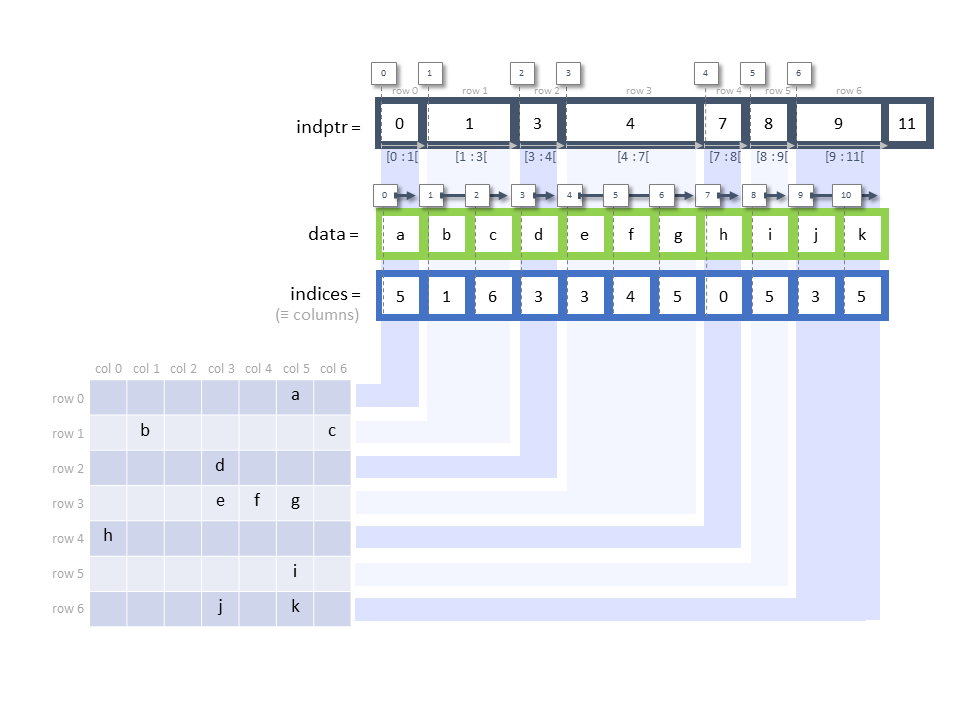

In [285]:
Image(filename = "./sparse_data_internals.png")

# Task 2: Learning the Sparse Data Manipulation (12 points)
In the picture above, each row is a point, as our data is laid out in row-wise. Essentially, all the data is laid out in sequentially in memory to optimize performance (e.g. locality). **indptr** gives the beginning index in this sequential layer for each point (row). For example, **indptr[3] = 4** and **indptr[4] = 7** gives you the starting and the ending index for the *point 3*. In addition, **0**'s are never stored in **scipy.sparse.csr_matrix** (unless computation modifies a previously non-zero entry), and **indices** gives the feature numbers corresponding to the non-zero entries.

In order to write efficient code using scipy.sparse.csr_matrix, you should use **indptr**, **data**, and **indices** variables to access the data. For example, to access the *row 3* of the picture above, one will write a for-loop like the following:

```python
def operate_on_scipy_sparse_matrix(X_data, X_indptr, X_indices):
    for row in range(X.shape[0]):
        for index in range(X.indptr[row], X.indptr[row]):
            feature_num = X.indices[ index ]
            print('Feature #', feature_num, ' has value ', X.data[index])

# Some data matrix here.
X = scipy.sparse.csr_matrix(...)
operate_on_scipy_sparse_matrix(X.data, X.indptr, X.indices)
```

In factorization machine, the prediction requires evaluating the following:
$$\hat{f}(\mathbf{x}) = w_0 + \mathbf{w}^T \mathbf{x} + 
\frac{1}{2}
\sum\limits_{f = 1}^k
\left ( 
    \left( \underbrace{v_f^T \mathbf{x}}_{\mbox{first dot product}} \right )^2 - 
\underbrace{\sum\limits_{j=1}^d v_{f, j}^2 x_j^2}_{\mbox{second dot product}}
    \right )
$$

Recall the factor matrix (in 2-D **numpy.array**)
$$\mathbf{V} = \begin{bmatrix}
\leftarrow & \mathbf{v}_1^T & \rightarrow  \\
 & \vdots & \\
 \leftarrow & \mathbf{v}_k^T & \rightarrow  \\
\end{bmatrix} \in \mathbb{R}^{k \times d}$$
and the data matrix (in **scipy.sparse.csr_matrix**) $$\mathbf{X} = \begin{bmatrix}
\leftarrow & \mathbf{x}_1^T & \rightarrow  \\
 & \vdots & \\
 \leftarrow & \mathbf{x}_k^T & \rightarrow  \\
\end{bmatrix} \in \mathbb{R}^{N \times d}$$

**Question (6 points) **: Recall that $\mathbf{x} \in \mathbb{R}^d$ is extremely sparse. If you are in doubt, you may want to recall that one-hot-encoding for a fairly low-dimensional Criteo data used in the previous assignment produced more features. You can imagine what this could do for categorical data with features taking multiple values.

Suppose a single input $\mathbf{x}$ has $N_z(\mathbf{x})$ non-zero entries. What is the complexity of evaluating $$\hat{f}(\mathbf{x}) = w_0 + \mathbf{w}^T \mathbf{x} + 
\frac{1}{2}
\sum\limits_{f = 1}^k
\left ( 
    \left( \underbrace{v_f^T \mathbf{x}}_{\mbox{first dot product}} \right )^2 - 
\underbrace{\sum\limits_{j=1}^d v_{f, j}^2 x_j^2}_{\mbox{second dot product}}
    \right )$$
Please provide your answer to this question in the following Python function returning a string. Your answer should be in big O notation, e.g. $O(...)$ where the inside expression is possibly in terms of $d$, $k$, 
$N_z(\mathbf{x})$, $N$.

In [286]:
def prediction_complexity():
    return 'O(kNz(x))'

**Task (3 points)**:
After you answer the previous question, you may be enlightened why sparse data makes evaluation much faster. Armed with this knowledge, let us move onto the implementation part.
First, let us tackle the computation of $\mathbf{w}^T \mathbf{x}$. Keep in mind that $\mathbf{w}$ is usually a dense vector whereas our feature vector $\mathbf{x} \in \mathbb{R}^d$ is extremely sparse. The key idea is to leverage the sparsity in $\mathbb{x}$ to speed up the evaluation. Please write a function that computes this dot product (see the TODO tag below for the function **compute_dot_between_dense_and_sparse**)

**Task (3 points)**:
After you complete the first function, let us tackle the computing the cross terms in factorization machine. Using the logic above, write a small function to evaluate the product between a **scipy.sparse.csr_matrix** and a 1-dimensional **numpy.array**. **compute_dot_products** function computes the two quantities.
1. The product between $V$ and the row *point_id* or $\mathbf{X}$ ( $\in \mathbb{R}^d$); you need $k$ of the **first dot product** for $1 \leq f \leq k$.
2. The product between $V \odot V$ and $X[point\_id] \odot X[point\_id]$ ($\in \mathbb{R}^d$) where $\odot$ denotes the Hadamard product (https://en.wikipedia.org/wiki/Hadamard_product_(matrices)); you need $k$ of the **second dot product** for $1 \leq f \leq k$.

In [300]:
## TODO: computes the dot product between a 1-D numpy.array and a given row in another scipy.sparse.csr_matrix.
#
#  w: the weight vector (1-D numpy.array in $\mathbb{R}^d$)
#  X_data: the scipy.sparse.csr_matrix holding the row oriented data ($N \times d$). This is the raw data pointer.
#  X_indptr: the beginning index of each of the row in $X$ scipy.sparse.csr_matrix.
#  X_indices: the corresponding feature numbers.
#  point_id: the row number from $X$ to access.
#
#  Returns the $\mathbf{w}^T X[point_id]$

def compute_dot_between_dense_and_sparse(w, X_data, X_indptr, X_indices, point_id):
    sum = 0
    #print(X_data)
    #print(w)
    #print(X_indptr)
    
    for index in range(X_indptr[point_id], X_indptr[point_id + 1]):
        #print (index)
        feature_num = X_indices[ index ]
        sum += X_data[index]*w.T[feature_num] 
            
    return sum

## TODO: computes the products between a 2-D numpy.array and a given row in another scipy.sparse.csr_matrix.
#
#  V: the 2-D numpy.array ($k \times d$).
#  X_data: the scipy.sparse.csr_matrix holding the row oriented data ($N \times d$). This is the raw data pointer.
#  X_indptr: the beginning index of each of the row in $X$ scipy.sparse.csr_matrix.
#  X_indices: the corresponding feature numbers.
#  point_id: the row number from $X$ to access.
#
#  Returns the products $V ( X[point_id] )^T  \in \mathbb{R}^k$ and $(V \odot V) (X[point_id] \odot
#  X[point_id]) \in \mathbb{R}^k$

def compute_dot_products(V, X_data, X_indptr, X_indices, point_id):
    dot_products = numpy.zeros((V.shape[0],))
    squared_dot_products = numpy.zeros((V.shape[0],))
    #print(V)
    #for row in range(X.shape[0]):
    for index in range(X_indptr[point_id], X_indptr[point_id+1]):
        feature_num = X_indices[ index ]
        #for column in range(V.shape[1]):
        dot_products += X_data[index]*V.T[feature_num]
        squared_dot_products += numpy.square(X_data[index])*numpy.square(V.T[feature_num])
        
    return dot_products, squared_dot_products

# Call sanity test. At the end, it should print "All tests passed..."
sanity_test_sparse_data()

Test # 0
-------------


Testing the compute_dot_products
V matrix: 
[[ 1  0 -3 -2]
 [ 3  2 -1  1]
 [-2  3  2 -1]
 [ 3  3 -3 -2]
 [-1 -2  4  2]
 [-3  3 -1  0]]
X matrix: 
  (0, 1)	9
  (1, 2)	3
  (2, 0)	3
  (2, 3)	1
point_id from X matrix:  2
Naive dot products:  [ 1 10 -7  7 -1 -9]
Naive squared dot products:  [13 82 37 85 13 81]
Fast dot products:  [ 1. 10. -7.  7. -1. -9.]
Fast squared dot products:  [13. 82. 37. 85. 13. 81.]


Testing the compute_dot_between_dense_and_sparse
The weight vector:  [-7 -9 -6 -3]
Naive dot product:  -24
Fast dot product:  -24
Test # 1
-------------


Testing the compute_dot_products
V matrix: 
[[-1  0  2  2]
 [ 2  4  3 -2]
 [ 1  3  3  1]
 [-3  0 -2 -2]
 [-1  0 -3 -3]
 [ 4  1  2 -1]]
X matrix: 
  (0, 1)	1
  (1, 2)	3
  (2, 0)	1
  (2, 3)	8
point_id from X matrix:  1
Naive dot products:  [ 6  9  9 -6 -9  6]
Naive squared dot products:  [36 81 81 36 81 36]
Fast dot products:  [ 6.  9.  9. -6. -9.  6.]
Fast squared dot products:  [36. 81. 81. 36. 81. 36.]


Te

# Task 3: Implementing the Prediction Function (2 points)
If you are able to pass the previous checkpoint, then you are ready to implement the following function which outputs $$\hat{f}(\mathbf{x}) = w_0 + \mathbf{w}^T \mathbf{x} + 
\frac{1}{2}
\sum\limits_{f = 1}^k
\left ( 
    \left( v_f^T \mathbf{x} \right )^2 - 
\sum\limits_{j=1}^d v_{f, j}^2 x_j^2
    \right )
$$
You may find the functions implemented in the previous part useful. See the TODO tag below.

In [288]:
## TODO: For $\mathbf{x}$ which is the row point_id of the sparse data whose representation is
#        given by (data, indptr, indices) variable set, return the $\hat{f}(\mathbf{x})$ and the 
#        feature factor dot product $v_f^T \mathbf{x}$ for $1 \leq f \leq k$.
#
#  X_data: the scipy.sparse.csr_matrix holding the row oriented data ($N \times d$). This is the raw data pointer.
#  X_indptr: the beginning index of each of the row in $X$ scipy.sparse.csr_matrix.
#  X_indices: the corresponding feature numbers.
#  w0: the bias (1-D numpy.array, this variable can be modified) \in \mathbb{R}
#  w: the weight vector (1-D numpy.array, this variable can be modified) \in \mathbb{R}^d
#  V: the factor matrix (2-D numpy.array, this variable can be modified) \in \mathbb{R}^{k \times d}
#  n_factors: this is the $k$ in our formulation, e.g. number of factors.
#  point_id: the row number from $X$ to access.
#
#  Returns the $\hat{f}(\mathbf{x})$ and the dot products between each of the factors and the $\mathbf{x}$.

def predict_instance(X_data, X_indptr, X_indices, w0, w, V, n_factors, point_id):
    #print("n_factor",n_factors)
    #print("V.shape is",V.shape)
    #print("X shape", X_data.shape)
    #print(X_data)
    # Initialize the prediction to the bias first.
    pred = w0[0]
    #print("first", pred)
    # Add the linear term. Some code here...
    pred += compute_dot_between_dense_and_sparse(w.T, X_data, X_indptr, X_indices, point_id)
    #dot_products, squared_dot_products = compute_dot_products(V, X_data, X_indptr, X_indices, point_id)
    #pred += 1/2*numpy.sum(numpy.square(dot_products))
    #print("second", pred)
    # Add the cross terms. Some code here...
    #dot_products, squared_dot_products = compute_dot_products(V, X_data, X_indptr, X_indices, point_id)
    for row in range(n_factors): #k
        #dot_product = compute_dot_between_dense_and_sparse(V[row].T, X_data, X_indptr, X_indices, point_id)
        #pred += 1/2*numpy.square(dot_product)
        #print("dot prod", dot_product)
        #for col in range(V.shape[1]): #d
            #squared_dot_products = compute_dot_products(V, X_data, X_indptr, X_indices, point_id)[1]
        #print("row", V[row])
        #print("V", V)
        dot_products, squared_dot_products = compute_dot_products(V, X_data, X_indptr, X_indices, point_id)
        #print("sqred", squared_dot_products,)
        pred += 1/2*numpy.sum(numpy.square(dot_products)[row])
        pred -= 1/2*numpy.sum(squared_dot_products[row])
            #print("X_indices[col]", X_indices[col])
            #print("col", col)
            #pred -= 0.5*squared_dot_products
    #print("squared d", squared_dot_products)
    #print("dot", dot_products)
    #print("sqe", numpy.square(dot_products))
    # Returns the $\hat{f}(\mathbf{x})$ and the dot products between each of the factors and the $\mathbf{x}$.
    # You should replace the second argument of this return statement...
    #print(dot_products)
    
    
    #print("third", pred)
    return pred, dot_products

# This function should print out "Prediction function passes the test..."
test_prediction()

[6 1 2 3 3 6 1 4 5]
[9 2]
[0 2 4 5 7 9]
0
1
298.0 298
[6 1 2 3 3 6 1 4 5]
[9 2]
[0 2 4 5 7 9]
2
3
266.0 266
[6 1 2 3 3 6 1 4 5]
[9 2]
[0 2 4 5 7 9]
4
29.0 29
[6 1 2 3 3 6 1 4 5]
[9 2]
[0 2 4 5 7 9]
5
6
298.0 298
[6 1 2 3 3 6 1 4 5]
[9 2]
[0 2 4 5 7 9]
7
8
848.0 848
Prediction function passes the test...


# Task 4: Implementing the Stochastic Gradient Descent (2 points)

Once you are here, now you are ready to implement the stochastic gradient descent algorithm for FMs. Please implement the inner loop that iterates over all the data points in Algorithm 1 in the factorization machines paper (without the **repeat**/**until** which iterates over the epochs).

In [295]:
## TODO: Performs one pass over the training data in the order specified by training_data_indices numpy.array.
#        Applies a SGD update using only one point using the algorithm above.
#
#  training_data_indices: the numpy.array (1-D) containing the order in which the training data X, Y should
#                         be examined.
#  X_data: the scipy.sparse.csr_matrix holding the row oriented data ($N \times d$). This is the raw data pointer.
#  X_indptr: the beginning index of each of the row in $X$ scipy.sparse.csr_matrix.
#  X_indices: the corresponding feature numbers.
#  y: numpy.array (1-D) containing the labels.
#  w0: the bias (1-D numpy.array, this variable can be modified) \in \mathbb{R}
#  w: the weight vector (1-D numpy.array, this variable can be modified) \in \mathbb{R}^d
#  V: the factor matrix (2-D numpy.array, this variable can be modified) \in \mathbb{R}^{k \times d}
#  n_factors: this is the $k$ in our formulation, e.g. number of factors.
#  learning rate: $\eta$ for learning rate.
#  regularization: $\lambda$ regularizer.
#  loss function: the function that takes $y$ and $\hat{f}(\mathbf{x})$ and outputs the loss.
#  partial_derivative_loss_function: the function that takes $y$ and $\hat{f}(\mathbf{x})$ and outputs
#                                    the partial derivative with respect to the output $\hat{f}(\mathbf{x})$.

def sgd_update(
    training_data_indices, X_data, X_indptr, X_indices, y, 
    w0, w, V, n_factors, learning_rate, regularization, loss_function, partial_derivative_loss_function):
    #print("typs is", type(V))
    total_loss = 0
    for point_id in training_data_indices:
        
        # Predict on the instance and get the dot products with the factors.
        pred, dot_products = predict_instance(X_data, X_indptr, X_indices, w0, w, V, n_factors, point_id)
           
        # calculate loss gradient. Some code here...
        total_loss += loss_function(y[point_id], pred)
        loss_gradient = partial_derivative_loss_function(y[point_id],pred)
        # update bias/intercept term. Some code here...
        w0[0] = w0[0] - learning_rate*loss_gradient 
        
        # update weight. Some code here...
        for index in range(X_indptr[point_id], X_indptr[point_id + 1]):
            feature_num = X_indices[index]
            w[feature_num] -= learning_rate * (loss_gradient * X_data[index] +  regularization * w[feature_num])
        

        # update factor. Some code here...
        for factor in range(n_factors):
            for index in range(X_indptr[point_id], X_indptr[point_id + 1]):
                feature_num = X_indices[index]
                V_derivative = loss_gradient*(dot_products[factor] - V[factor,feature_num]*X_data[index])*X_data[index]
                V[factor, feature_num] -= learning_rate * (V_derivative + regularization*V[factor, feature_num])
        
    total_loss /= len(training_data_indices)
        
    # The following is just to make sure the code compiles.
    return total_loss

# Task 5: Finishing Touches (2 points)
Please complete the remaining module in the **fm_model** class below. See the TODO tags.

In [301]:
class fm_model:

    ## TODO: Initializes the various parameters (training, validation sets) as well as
    #  the model parameters defining a FM model.
    #
    #  X_train: training data in scipy.sparse.csr_matrix
    #  Y_train: training label in numpy.array
    #  X_validation: validation data in scipy.sparse.csr_matrix
    #  Y_validation: validation label in numpy.array
    #  num_factors: $k$ latent factors.
    #  random_state: the random number seed.
    #  task: whether the FM model is classification or regression.
    def __init__(
        self, X_train, Y_train, X_validation, Y_validation, 
        num_factors = 12, random_state = 1000, task='classification'):

        # Set train/validation sets, number of factors $k$ and random seed.
        self.X_train_ = X_train
        self.Y_train_ = Y_train
        self.X_validation_ = X_validation
        self.Y_validation_ = Y_validation
        self.num_factors_ = num_factors
        self.random_state_ = random_state
        
        # Initialize the model parameter.
        self.intercept_ = numpy.zeros((1,))
        self.coef_ = numpy.zeros(self.X_train_.shape[1])
        
        # TODO: Complete me. Initialize each of the factor matrix entries with a mean of 0 and
        # a standard deviation of 1 / sqrt(number of latent factor). Replace the right hand side
        # with the appropriate numpy.array.
        self.feature_factors_ = numpy.random.normal(loc = 0, scale = 1/numpy.sqrt(num_factors), size = (num_factors, X_train.shape[1]))
        
        if task == 'classification':
            print('Task is classification...')
            self.loss_function_ = log_loss
            self.partial_derivative_loss_function_ = partial_derivative_log_loss
            self.batch_predict_function_ = self.batch_logistic
            self.avg_loss_function_ = self.avg_log_loss
        else:
            print('Task is regression...')
            self.loss_function_ = squared_loss
            self.partial_derivative_loss_function_ = partial_derivative_squared_loss
            self.batch_predict_function_ = self.batch_regress
            self.avg_loss_function_ = self.avg_sq_loss
    
    ## Trains the FM model.
    #
    #  num_epochs: the number of epochs to run.
    #  learning_rate: $\eta$
    #  rgularization: $\lambda$ regularizer.
    def train(self, num_epochs=10, learning_rate=0.1, regularization=0.1):
        n_samples, n_features = self.X_train_.shape        
        numpy.random.seed(self.random_state_)        
        self.validation_history_ = []
        self.training_history_ = []
        
        training_data_indices = numpy.arange( n_samples )
        for epoch in trange(num_epochs):
                        
            # Shuffle the indices and perform one pass over the training set.
            numpy.random.shuffle(training_data_indices)
            loss = sgd_update(
                training_data_indices, 
                self.X_train_.data, self.X_train_.indptr, self.X_train_.indices, self.Y_train_, 
                self.intercept_, self.coef_, self.feature_factors_, self.num_factors_,
                learning_rate, regularization, 
                self.loss_function_, self.partial_derivative_loss_function_)
            
            # Compute the validation loss.
            self.validation_history_.append(self.avg_loss_function_(self.X_validation_, self.Y_validation_))
                     
            # Compute the training loss.        
            self.training_history_.append(self.avg_loss_function_(self.X_train_, self.Y_train_))

    ## Computes batch logistic on a given input set using the FM model.
    def batch_logistic(self, X):
        pred = self.batch_regress(X)
        return 1.0 / (1.0 + numpy.exp(-pred))

    ## Computes the average log loss on the given $(X, Y)$ data pairs.
    def avg_log_loss(self, X, Y):
        batch_pred = self.batch_logistic(X)
        return numpy.mean([log_loss(y, y_hat) for y_hat, y in zip(batch_pred, Y)] )
        
    ## Computes the batch regression on a given input set using the FM model.
    def batch_regress(self, X):
        return numpy.array(
            [  predict_instance(
                X.data, X.indptr, X.indices, self.intercept_, self.coef_, 
                self.feature_factors_, self.feature_factors_.shape[0], point_id)[0] \
             for point_id in range(X.shape[0])] )
    
    ## Computes the average squared loss on the given $(X, Y)$ data pairs.
    def avg_sq_loss(self, X, Y):
        batch_pred = self.batch_regress(X)
        return numpy.mean([squared_loss(y, y_hat) for y_hat, y in zip(batch_pred, Y)] )

# Testing Your Code
You are now ready to run your code on the Criteo dataset and the MovieLens dataset. For each of these test cases, you may wish to tune the number of factors $k$ and find out what works the best. For classification test cases, see how this compares to the results in the previous assignment using logistic regression. For this part, no writeup is required and doing additional analysis is up to you.

Keep in mind that SGD methods converge quickly in the few first ierations. Usually, these methods are stopped early and the ending iterates are used as a warm start for another optimization. You may want to try this technique to improve your model.

In [ ]:
test_movie_lens_data(num_factors=5, task='regression')












  0%|          | 0/300 [00:00<?, ?it/s]

90570  training points found with the features: 
[('userid', '<i8'), ('movieid', '<i8'), ('rating', '<i8'), ('timestamp', 'S20')]
A total of  4  features.
90570  training points found with the features: 
{'names':['userid','movieid','rating'], 'formats':['<i8','<i8','<i8'], 'offsets':[0,8,16], 'itemsize':44}
A total of  3  features.
Divided into the training set of size  72456
and the validation set of size  18114
After one-hot-encoding: the training set has  (72456, 2623)
Validation set has  (18114, 2623)
Task is regression...
typs is <class 'numpy.ndarray'>













  0%|          | 1/300 [00:29<2:25:39, 29.23s/it]

typs is <class 'numpy.ndarray'>













  1%|          | 2/300 [01:00<2:28:52, 29.98s/it]

typs is <class 'numpy.ndarray'>













  1%|          | 3/300 [01:31<2:28:58, 30.09s/it]

typs is <class 'numpy.ndarray'>













  1%|▏         | 4/300 [02:04<2:33:39, 31.15s/it]

typs is <class 'numpy.ndarray'>













  2%|▏         | 5/300 [02:37<2:34:36, 31.45s/it]

typs is <class 'numpy.ndarray'>













  2%|▏         | 6/300 [03:08<2:33:39, 31.36s/it]

typs is <class 'numpy.ndarray'>













  2%|▏         | 7/300 [03:39<2:33:13, 31.38s/it]

typs is <class 'numpy.ndarray'>













  3%|▎         | 8/300 [04:10<2:31:44, 31.18s/it]

typs is <class 'numpy.ndarray'>













  3%|▎         | 9/300 [04:41<2:30:48, 31.09s/it]

typs is <class 'numpy.ndarray'>













  3%|▎         | 10/300 [05:14<2:33:59, 31.86s/it]

typs is <class 'numpy.ndarray'>













  4%|▎         | 11/300 [05:47<2:33:56, 31.96s/it]

typs is <class 'numpy.ndarray'>













  4%|▍         | 12/300 [06:21<2:36:26, 32.59s/it]

typs is <class 'numpy.ndarray'>













  4%|▍         | 13/300 [06:53<2:36:12, 32.66s/it]

typs is <class 'numpy.ndarray'>













  5%|▍         | 14/300 [07:28<2:37:38, 33.07s/it]

typs is <class 'numpy.ndarray'>













  5%|▌         | 15/300 [08:01<2:37:07, 33.08s/it]

typs is <class 'numpy.ndarray'>













  5%|▌         | 16/300 [08:35<2:38:48, 33.55s/it]

typs is <class 'numpy.ndarray'>













  6%|▌         | 17/300 [09:07<2:35:26, 32.96s/it]

typs is <class 'numpy.ndarray'>













  6%|▌         | 18/300 [09:40<2:35:38, 33.12s/it]

typs is <class 'numpy.ndarray'>













  6%|▋         | 19/300 [10:13<2:34:09, 32.92s/it]

typs is <class 'numpy.ndarray'>













  7%|▋         | 20/300 [10:45<2:32:08, 32.60s/it]

typs is <class 'numpy.ndarray'>













  7%|▋         | 21/300 [11:20<2:34:54, 33.31s/it]

typs is <class 'numpy.ndarray'>













  7%|▋         | 22/300 [11:49<2:28:29, 32.05s/it]

typs is <class 'numpy.ndarray'>













  8%|▊         | 23/300 [12:18<2:24:23, 31.28s/it]

typs is <class 'numpy.ndarray'>













  8%|▊         | 24/300 [12:50<2:24:43, 31.46s/it]

typs is <class 'numpy.ndarray'>













  8%|▊         | 25/300 [13:20<2:21:30, 30.88s/it]

typs is <class 'numpy.ndarray'>













  9%|▊         | 26/300 [13:49<2:19:00, 30.44s/it]

typs is <class 'numpy.ndarray'>













  9%|▉         | 27/300 [14:19<2:17:18, 30.18s/it]

typs is <class 'numpy.ndarray'>













  9%|▉         | 28/300 [14:49<2:16:51, 30.19s/it]

typs is <class 'numpy.ndarray'>













 10%|▉         | 29/300 [15:18<2:15:31, 30.00s/it]

typs is <class 'numpy.ndarray'>













 10%|█         | 30/300 [15:48<2:14:30, 29.89s/it]

typs is <class 'numpy.ndarray'>













 10%|█         | 31/300 [16:17<2:13:21, 29.75s/it]

typs is <class 'numpy.ndarray'>













 11%|█         | 32/300 [16:47<2:12:20, 29.63s/it]

typs is <class 'numpy.ndarray'>













 11%|█         | 33/300 [17:18<2:14:14, 30.17s/it]

typs is <class 'numpy.ndarray'>













 11%|█▏        | 34/300 [17:47<2:12:20, 29.85s/it]

typs is <class 'numpy.ndarray'>













 12%|█▏        | 35/300 [18:17<2:11:04, 29.68s/it]

typs is <class 'numpy.ndarray'>













 12%|█▏        | 36/300 [18:46<2:09:59, 29.54s/it]

typs is <class 'numpy.ndarray'>













 12%|█▏        | 37/300 [19:16<2:10:46, 29.83s/it]

typs is <class 'numpy.ndarray'>













 13%|█▎        | 38/300 [19:45<2:09:24, 29.64s/it]

typs is <class 'numpy.ndarray'>













 13%|█▎        | 39/300 [20:15<2:08:22, 29.51s/it]

typs is <class 'numpy.ndarray'>













 13%|█▎        | 40/300 [20:44<2:07:32, 29.43s/it]

typs is <class 'numpy.ndarray'>













 14%|█▎        | 41/300 [21:15<2:09:05, 29.90s/it]

typs is <class 'numpy.ndarray'>













 14%|█▍        | 42/300 [21:45<2:08:54, 29.98s/it]

typs is <class 'numpy.ndarray'>













 14%|█▍        | 43/300 [22:15<2:08:00, 29.89s/it]

typs is <class 'numpy.ndarray'>













 15%|█▍        | 44/300 [22:47<2:10:17, 30.54s/it]

typs is <class 'numpy.ndarray'>













 15%|█▌        | 45/300 [23:22<2:15:26, 31.87s/it]

typs is <class 'numpy.ndarray'>













 15%|█▌        | 46/300 [23:53<2:13:51, 31.62s/it]

typs is <class 'numpy.ndarray'>













 16%|█▌        | 47/300 [24:23<2:11:05, 31.09s/it]

typs is <class 'numpy.ndarray'>













 16%|█▌        | 48/300 [24:53<2:10:08, 30.99s/it]

typs is <class 'numpy.ndarray'>













 16%|█▋        | 49/300 [25:24<2:08:45, 30.78s/it]

typs is <class 'numpy.ndarray'>













 17%|█▋        | 50/300 [25:55<2:09:24, 31.06s/it]

typs is <class 'numpy.ndarray'>













 17%|█▋        | 51/300 [26:26<2:08:46, 31.03s/it]

typs is <class 'numpy.ndarray'>













 17%|█▋        | 52/300 [26:58<2:08:51, 31.17s/it]

typs is <class 'numpy.ndarray'>













 18%|█▊        | 53/300 [27:29<2:08:33, 31.23s/it]

typs is <class 'numpy.ndarray'>













 18%|█▊        | 54/300 [28:00<2:07:56, 31.20s/it]

typs is <class 'numpy.ndarray'>













 18%|█▊        | 55/300 [28:31<2:06:25, 30.96s/it]

typs is <class 'numpy.ndarray'>













 19%|█▊        | 56/300 [29:01<2:04:41, 30.66s/it]

typs is <class 'numpy.ndarray'>













 19%|█▉        | 57/300 [29:30<2:03:02, 30.38s/it]

typs is <class 'numpy.ndarray'>













 19%|█▉        | 58/300 [30:00<2:01:50, 30.21s/it]

typs is <class 'numpy.ndarray'>













 20%|█▉        | 59/300 [30:31<2:01:44, 30.31s/it]

typs is <class 'numpy.ndarray'>













 20%|██        | 60/300 [31:02<2:01:50, 30.46s/it]

typs is <class 'numpy.ndarray'>













 20%|██        | 61/300 [31:32<2:01:41, 30.55s/it]

typs is <class 'numpy.ndarray'>













 21%|██        | 62/300 [32:02<1:59:47, 30.20s/it]

typs is <class 'numpy.ndarray'>













 21%|██        | 63/300 [32:33<2:00:28, 30.50s/it]

typs is <class 'numpy.ndarray'>













 21%|██▏       | 64/300 [33:03<1:59:40, 30.43s/it]

typs is <class 'numpy.ndarray'>













 22%|██▏       | 65/300 [33:35<2:00:16, 30.71s/it]

typs is <class 'numpy.ndarray'>













 22%|██▏       | 66/300 [34:07<2:01:31, 31.16s/it]

typs is <class 'numpy.ndarray'>













 22%|██▏       | 67/300 [34:37<1:59:25, 30.75s/it]

typs is <class 'numpy.ndarray'>













 23%|██▎       | 68/300 [35:06<1:57:20, 30.35s/it]

typs is <class 'numpy.ndarray'>













 23%|██▎       | 69/300 [35:35<1:55:47, 30.07s/it]

typs is <class 'numpy.ndarray'>













 23%|██▎       | 70/300 [36:05<1:55:12, 30.05s/it]

typs is <class 'numpy.ndarray'>













 24%|██▎       | 71/300 [36:35<1:53:37, 29.77s/it]

typs is <class 'numpy.ndarray'>













 24%|██▍       | 72/300 [37:08<1:57:11, 30.84s/it]

typs is <class 'numpy.ndarray'>













 24%|██▍       | 73/300 [37:39<1:56:32, 30.80s/it]

typs is <class 'numpy.ndarray'>













 25%|██▍       | 74/300 [38:09<1:55:13, 30.59s/it]

typs is <class 'numpy.ndarray'>













 25%|██▌       | 75/300 [38:39<1:54:00, 30.40s/it]

typs is <class 'numpy.ndarray'>













 25%|██▌       | 76/300 [39:09<1:53:03, 30.28s/it]

typs is <class 'numpy.ndarray'>













 26%|██▌       | 77/300 [39:39<1:52:06, 30.16s/it]

typs is <class 'numpy.ndarray'>













 26%|██▌       | 78/300 [40:08<1:51:14, 30.06s/it]

typs is <class 'numpy.ndarray'>













 26%|██▋       | 79/300 [40:39<1:50:46, 30.07s/it]

typs is <class 'numpy.ndarray'>













 27%|██▋       | 80/300 [41:08<1:50:06, 30.03s/it]

typs is <class 'numpy.ndarray'>













 27%|██▋       | 81/300 [41:39<1:49:38, 30.04s/it]

typs is <class 'numpy.ndarray'>













 27%|██▋       | 82/300 [42:09<1:49:13, 30.06s/it]

typs is <class 'numpy.ndarray'>













 28%|██▊       | 83/300 [42:39<1:48:34, 30.02s/it]

typs is <class 'numpy.ndarray'>













 28%|██▊       | 84/300 [43:09<1:48:04, 30.02s/it]

typs is <class 'numpy.ndarray'>













 28%|██▊       | 85/300 [43:38<1:47:28, 29.99s/it]

typs is <class 'numpy.ndarray'>













 29%|██▊       | 86/300 [44:08<1:46:39, 29.90s/it]

typs is <class 'numpy.ndarray'>













 29%|██▉       | 87/300 [44:38<1:46:05, 29.89s/it]

typs is <class 'numpy.ndarray'>













 29%|██▉       | 88/300 [45:08<1:45:27, 29.85s/it]

typs is <class 'numpy.ndarray'>













 30%|██▉       | 89/300 [45:38<1:44:50, 29.81s/it]

typs is <class 'numpy.ndarray'>













 30%|███       | 90/300 [46:11<1:47:48, 30.80s/it]

typs is <class 'numpy.ndarray'>













 30%|███       | 91/300 [46:43<1:48:49, 31.24s/it]

typs is <class 'numpy.ndarray'>













 31%|███       | 92/300 [47:13<1:47:26, 30.99s/it]

typs is <class 'numpy.ndarray'>













 31%|███       | 93/300 [47:43<1:45:43, 30.65s/it]

typs is <class 'numpy.ndarray'>













 31%|███▏      | 94/300 [48:13<1:44:34, 30.46s/it]

typs is <class 'numpy.ndarray'>













 32%|███▏      | 95/300 [48:43<1:43:30, 30.29s/it]

typs is <class 'numpy.ndarray'>













 32%|███▏      | 96/300 [49:13<1:42:21, 30.11s/it]

typs is <class 'numpy.ndarray'>













 32%|███▏      | 97/300 [49:43<1:41:39, 30.05s/it]

typs is <class 'numpy.ndarray'>













 33%|███▎      | 98/300 [50:13<1:41:07, 30.04s/it]

typs is <class 'numpy.ndarray'>













 33%|███▎      | 99/300 [50:43<1:40:30, 30.00s/it]

typs is <class 'numpy.ndarray'>













 33%|███▎      | 100/300 [51:13<1:39:57, 29.99s/it]

typs is <class 'numpy.ndarray'>













 34%|███▎      | 101/300 [51:42<1:39:19, 29.95s/it]

typs is <class 'numpy.ndarray'>













 34%|███▍      | 102/300 [52:13<1:38:59, 30.00s/it]

typs is <class 'numpy.ndarray'>













 34%|███▍      | 103/300 [52:42<1:38:20, 29.95s/it]

typs is <class 'numpy.ndarray'>













 35%|███▍      | 104/300 [53:12<1:37:48, 29.94s/it]

typs is <class 'numpy.ndarray'>













 35%|███▌      | 105/300 [53:42<1:37:03, 29.87s/it]

typs is <class 'numpy.ndarray'>













 35%|███▌      | 106/300 [54:12<1:36:39, 29.89s/it]

typs is <class 'numpy.ndarray'>













 36%|███▌      | 107/300 [54:42<1:35:57, 29.83s/it]

typs is <class 'numpy.ndarray'>













 36%|███▌      | 108/300 [55:11<1:35:11, 29.75s/it]

typs is <class 'numpy.ndarray'>













 36%|███▋      | 109/300 [55:41<1:34:44, 29.76s/it]

typs is <class 'numpy.ndarray'>













 37%|███▋      | 110/300 [56:11<1:34:16, 29.77s/it]

typs is <class 'numpy.ndarray'>













 37%|███▋      | 111/300 [56:41<1:33:48, 29.78s/it]

typs is <class 'numpy.ndarray'>













 37%|███▋      | 112/300 [57:11<1:33:31, 29.85s/it]

typs is <class 'numpy.ndarray'>













 38%|███▊      | 113/300 [57:40<1:32:45, 29.76s/it]

typs is <class 'numpy.ndarray'>













 38%|███▊      | 114/300 [58:09<1:31:53, 29.64s/it]

typs is <class 'numpy.ndarray'>













 38%|███▊      | 115/300 [58:39<1:31:00, 29.52s/it]

typs is <class 'numpy.ndarray'>













 39%|███▊      | 116/300 [59:08<1:30:20, 29.46s/it]

typs is <class 'numpy.ndarray'>













 39%|███▉      | 117/300 [59:38<1:29:55, 29.48s/it]

typs is <class 'numpy.ndarray'>













 39%|███▉      | 118/300 [1:00:07<1:29:25, 29.48s/it]

typs is <class 'numpy.ndarray'>













 40%|███▉      | 119/300 [1:00:36<1:28:49, 29.44s/it]

typs is <class 'numpy.ndarray'>













 40%|████      | 120/300 [1:01:06<1:28:12, 29.40s/it]

typs is <class 'numpy.ndarray'>













 40%|████      | 121/300 [1:01:35<1:27:47, 29.43s/it]

typs is <class 'numpy.ndarray'>













 41%|████      | 122/300 [1:02:05<1:27:30, 29.50s/it]

typs is <class 'numpy.ndarray'>













 41%|████      | 123/300 [1:02:34<1:26:56, 29.47s/it]

typs is <class 'numpy.ndarray'>













 41%|████▏     | 124/300 [1:03:04<1:26:30, 29.49s/it]

typs is <class 'numpy.ndarray'>













 42%|████▏     | 125/300 [1:03:33<1:25:53, 29.45s/it]

typs is <class 'numpy.ndarray'>













 42%|████▏     | 126/300 [1:04:03<1:25:26, 29.46s/it]

typs is <class 'numpy.ndarray'>













 42%|████▏     | 127/300 [1:04:32<1:25:01, 29.49s/it]

typs is <class 'numpy.ndarray'>













 43%|████▎     | 128/300 [1:05:02<1:24:27, 29.46s/it]

typs is <class 'numpy.ndarray'>













 43%|████▎     | 129/300 [1:05:31<1:23:53, 29.44s/it]

typs is <class 'numpy.ndarray'>













 43%|████▎     | 130/300 [1:06:00<1:23:25, 29.44s/it]

typs is <class 'numpy.ndarray'>













 44%|████▎     | 131/300 [1:06:30<1:22:51, 29.41s/it]

typs is <class 'numpy.ndarray'>













 44%|████▍     | 132/300 [1:06:59<1:22:11, 29.35s/it]

typs is <class 'numpy.ndarray'>













 44%|████▍     | 133/300 [1:07:28<1:21:40, 29.34s/it]

typs is <class 'numpy.ndarray'>













 45%|████▍     | 134/300 [1:07:58<1:21:05, 29.31s/it]

typs is <class 'numpy.ndarray'>













 45%|████▌     | 135/300 [1:08:27<1:20:37, 29.32s/it]

typs is <class 'numpy.ndarray'>













 45%|████▌     | 136/300 [1:08:56<1:20:03, 29.29s/it]

typs is <class 'numpy.ndarray'>













 46%|████▌     | 137/300 [1:09:25<1:19:35, 29.30s/it]

typs is <class 'numpy.ndarray'>













 46%|████▌     | 138/300 [1:09:55<1:19:04, 29.29s/it]

typs is <class 'numpy.ndarray'>













 46%|████▋     | 139/300 [1:10:24<1:18:51, 29.39s/it]

typs is <class 'numpy.ndarray'>













 47%|████▋     | 140/300 [1:10:58<1:21:29, 30.56s/it]

typs is <class 'numpy.ndarray'>













 47%|████▋     | 141/300 [1:11:30<1:22:47, 31.24s/it]

typs is <class 'numpy.ndarray'>













 47%|████▋     | 142/300 [1:12:01<1:21:46, 31.05s/it]

typs is <class 'numpy.ndarray'>













 48%|████▊     | 143/300 [1:12:30<1:19:53, 30.53s/it]

typs is <class 'numpy.ndarray'>













 48%|████▊     | 144/300 [1:13:00<1:18:26, 30.17s/it]

typs is <class 'numpy.ndarray'>













 48%|████▊     | 145/300 [1:13:29<1:17:23, 29.96s/it]

typs is <class 'numpy.ndarray'>













 49%|████▊     | 146/300 [1:14:01<1:18:05, 30.42s/it]

typs is <class 'numpy.ndarray'>













 49%|████▉     | 147/300 [1:14:33<1:18:41, 30.86s/it]

typs is <class 'numpy.ndarray'>













 49%|████▉     | 148/300 [1:15:04<1:18:18, 30.91s/it]

typs is <class 'numpy.ndarray'>













 50%|████▉     | 149/300 [1:15:37<1:19:36, 31.63s/it]

typs is <class 'numpy.ndarray'>













 50%|█████     | 150/300 [1:16:08<1:18:53, 31.55s/it]

typs is <class 'numpy.ndarray'>













 50%|█████     | 151/300 [1:16:40<1:18:19, 31.54s/it]

typs is <class 'numpy.ndarray'>













 51%|█████     | 152/300 [1:17:09<1:16:08, 30.87s/it]

typs is <class 'numpy.ndarray'>













 51%|█████     | 153/300 [1:17:38<1:14:17, 30.32s/it]

typs is <class 'numpy.ndarray'>













 51%|█████▏    | 154/300 [1:18:07<1:12:48, 29.92s/it]

typs is <class 'numpy.ndarray'>













 52%|█████▏    | 155/300 [1:18:37<1:12:16, 29.90s/it]

typs is <class 'numpy.ndarray'>













 52%|█████▏    | 156/300 [1:19:06<1:11:10, 29.66s/it]

typs is <class 'numpy.ndarray'>













 52%|█████▏    | 157/300 [1:19:35<1:10:13, 29.46s/it]

typs is <class 'numpy.ndarray'>













 53%|█████▎    | 158/300 [1:20:06<1:10:58, 29.99s/it]

typs is <class 'numpy.ndarray'>













 53%|█████▎    | 159/300 [1:20:38<1:11:30, 30.43s/it]

typs is <class 'numpy.ndarray'>













 53%|█████▎    | 160/300 [1:21:08<1:11:11, 30.51s/it]

typs is <class 'numpy.ndarray'>













 54%|█████▎    | 161/300 [1:21:40<1:11:28, 30.85s/it]

typs is <class 'numpy.ndarray'>













 54%|█████▍    | 162/300 [1:22:12<1:11:54, 31.27s/it]

typs is <class 'numpy.ndarray'>













 54%|█████▍    | 163/300 [1:22:45<1:12:15, 31.65s/it]

typs is <class 'numpy.ndarray'>













 55%|█████▍    | 164/300 [1:23:17<1:12:11, 31.85s/it]

typs is <class 'numpy.ndarray'>













 55%|█████▌    | 165/300 [1:23:46<1:09:48, 31.02s/it]

typs is <class 'numpy.ndarray'>













 55%|█████▌    | 166/300 [1:24:16<1:08:12, 30.54s/it]

typs is <class 'numpy.ndarray'>













 56%|█████▌    | 167/300 [1:24:45<1:06:52, 30.17s/it]

typs is <class 'numpy.ndarray'>













 56%|█████▌    | 168/300 [1:25:16<1:06:39, 30.30s/it]

typs is <class 'numpy.ndarray'>













 56%|█████▋    | 169/300 [1:25:45<1:05:42, 30.09s/it]

typs is <class 'numpy.ndarray'>













 57%|█████▋    | 170/300 [1:26:14<1:04:40, 29.85s/it]

typs is <class 'numpy.ndarray'>













 57%|█████▋    | 171/300 [1:26:45<1:04:45, 30.12s/it]

typs is <class 'numpy.ndarray'>













 57%|█████▋    | 172/300 [1:27:16<1:04:23, 30.18s/it]

typs is <class 'numpy.ndarray'>













 58%|█████▊    | 173/300 [1:27:49<1:06:09, 31.26s/it]

typs is <class 'numpy.ndarray'>













 58%|█████▊    | 174/300 [1:28:21<1:05:40, 31.27s/it]

typs is <class 'numpy.ndarray'>













 58%|█████▊    | 175/300 [1:28:53<1:05:43, 31.55s/it]

typs is <class 'numpy.ndarray'>













 59%|█████▊    | 176/300 [1:29:23<1:04:38, 31.28s/it]

typs is <class 'numpy.ndarray'>













 59%|█████▉    | 177/300 [1:29:54<1:03:44, 31.09s/it]

typs is <class 'numpy.ndarray'>













 59%|█████▉    | 178/300 [1:30:26<1:03:38, 31.30s/it]

typs is <class 'numpy.ndarray'>













 60%|█████▉    | 179/300 [1:30:56<1:02:35, 31.04s/it]

typs is <class 'numpy.ndarray'>













 60%|██████    | 180/300 [1:31:26<1:01:24, 30.70s/it]

typs is <class 'numpy.ndarray'>













 60%|██████    | 181/300 [1:31:57<1:01:02, 30.77s/it]

typs is <class 'numpy.ndarray'>













 61%|██████    | 182/300 [1:32:26<59:37, 30.32s/it]  

typs is <class 'numpy.ndarray'>













 61%|██████    | 183/300 [1:32:59<1:00:31, 31.04s/it]

typs is <class 'numpy.ndarray'>













 61%|██████▏   | 184/300 [1:33:31<1:00:17, 31.19s/it]

typs is <class 'numpy.ndarray'>













 62%|██████▏   | 185/300 [1:34:03<1:00:41, 31.67s/it]

typs is <class 'numpy.ndarray'>













 62%|██████▏   | 186/300 [1:34:34<59:42, 31.42s/it]  

typs is <class 'numpy.ndarray'>













 62%|██████▏   | 187/300 [1:35:07<1:00:01, 31.87s/it]

typs is <class 'numpy.ndarray'>













 63%|██████▎   | 188/300 [1:35:39<59:29, 31.87s/it]  

typs is <class 'numpy.ndarray'>













 63%|██████▎   | 189/300 [1:36:09<57:54, 31.31s/it]

typs is <class 'numpy.ndarray'>













 63%|██████▎   | 190/300 [1:36:40<56:53, 31.03s/it]

typs is <class 'numpy.ndarray'>













 64%|██████▎   | 191/300 [1:37:12<56:57, 31.35s/it]

typs is <class 'numpy.ndarray'>













 64%|██████▍   | 192/300 [1:37:42<55:50, 31.03s/it]

typs is <class 'numpy.ndarray'>













 64%|██████▍   | 193/300 [1:38:13<55:20, 31.03s/it]

typs is <class 'numpy.ndarray'>













 65%|██████▍   | 194/300 [1:38:45<55:22, 31.34s/it]

typs is <class 'numpy.ndarray'>













 65%|██████▌   | 195/300 [1:39:17<55:04, 31.47s/it]

typs is <class 'numpy.ndarray'>













 65%|██████▌   | 196/300 [1:39:49<54:56, 31.70s/it]

typs is <class 'numpy.ndarray'>













 66%|██████▌   | 197/300 [1:40:20<54:05, 31.51s/it]

typs is <class 'numpy.ndarray'>













 66%|██████▌   | 198/300 [1:40:53<54:03, 31.80s/it]

typs is <class 'numpy.ndarray'>













 66%|██████▋   | 199/300 [1:41:23<52:38, 31.27s/it]

typs is <class 'numpy.ndarray'>













 67%|██████▋   | 200/300 [1:41:54<52:01, 31.22s/it]

typs is <class 'numpy.ndarray'>













 67%|██████▋   | 201/300 [1:42:24<51:16, 31.08s/it]

typs is <class 'numpy.ndarray'>













 67%|██████▋   | 202/300 [1:42:55<50:31, 30.93s/it]

typs is <class 'numpy.ndarray'>













 68%|██████▊   | 203/300 [1:43:27<50:29, 31.23s/it]

typs is <class 'numpy.ndarray'>













 68%|██████▊   | 204/300 [1:44:01<51:06, 31.94s/it]

typs is <class 'numpy.ndarray'>













 68%|██████▊   | 205/300 [1:44:33<50:44, 32.05s/it]

typs is <class 'numpy.ndarray'>













 69%|██████▊   | 206/300 [1:45:04<49:48, 31.79s/it]

typs is <class 'numpy.ndarray'>













 69%|██████▉   | 207/300 [1:45:33<48:09, 31.07s/it]

typs is <class 'numpy.ndarray'>













 69%|██████▉   | 208/300 [1:46:06<48:08, 31.39s/it]

typs is <class 'numpy.ndarray'>













 70%|██████▉   | 209/300 [1:46:40<48:49, 32.20s/it]

typs is <class 'numpy.ndarray'>













 70%|███████   | 210/300 [1:47:13<48:55, 32.62s/it]

typs is <class 'numpy.ndarray'>













 70%|███████   | 211/300 [1:47:47<48:54, 32.98s/it]

typs is <class 'numpy.ndarray'>













 71%|███████   | 212/300 [1:48:18<47:26, 32.34s/it]

typs is <class 'numpy.ndarray'>













 71%|███████   | 213/300 [1:48:52<47:29, 32.76s/it]

typs is <class 'numpy.ndarray'>













 71%|███████▏  | 214/300 [1:49:25<47:15, 32.97s/it]

typs is <class 'numpy.ndarray'>













 72%|███████▏  | 215/300 [1:50:03<48:48, 34.45s/it]

typs is <class 'numpy.ndarray'>













 72%|███████▏  | 216/300 [1:50:36<47:47, 34.14s/it]

typs is <class 'numpy.ndarray'>













 72%|███████▏  | 217/300 [1:51:08<46:08, 33.35s/it]

typs is <class 'numpy.ndarray'>













 73%|███████▎  | 218/300 [1:51:39<44:37, 32.65s/it]

typs is <class 'numpy.ndarray'>













 73%|███████▎  | 219/300 [1:52:11<43:56, 32.55s/it]

typs is <class 'numpy.ndarray'>













 73%|███████▎  | 220/300 [1:52:42<42:44, 32.06s/it]

typs is <class 'numpy.ndarray'>













 74%|███████▎  | 221/300 [1:53:16<42:48, 32.51s/it]

typs is <class 'numpy.ndarray'>













 74%|███████▍  | 222/300 [1:53:47<41:55, 32.25s/it]

typs is <class 'numpy.ndarray'>













 74%|███████▍  | 223/300 [1:54:19<40:57, 31.92s/it]

typs is <class 'numpy.ndarray'>













 75%|███████▍  | 224/300 [1:54:49<39:47, 31.41s/it]

typs is <class 'numpy.ndarray'>













 75%|███████▌  | 225/300 [1:55:20<39:10, 31.35s/it]

typs is <class 'numpy.ndarray'>













 75%|███████▌  | 226/300 [1:55:53<39:12, 31.79s/it]

typs is <class 'numpy.ndarray'>













 76%|███████▌  | 227/300 [1:56:24<38:38, 31.75s/it]

typs is <class 'numpy.ndarray'>













 76%|███████▌  | 228/300 [1:56:58<38:37, 32.18s/it]

typs is <class 'numpy.ndarray'>













 76%|███████▋  | 229/300 [1:57:27<37:11, 31.43s/it]

typs is <class 'numpy.ndarray'>













 77%|███████▋  | 230/300 [1:57:58<36:16, 31.09s/it]

typs is <class 'numpy.ndarray'>













 77%|███████▋  | 231/300 [1:58:28<35:26, 30.81s/it]

typs is <class 'numpy.ndarray'>













 77%|███████▋  | 232/300 [1:58:58<34:51, 30.76s/it]

typs is <class 'numpy.ndarray'>













 78%|███████▊  | 233/300 [1:59:30<34:30, 30.91s/it]

typs is <class 'numpy.ndarray'>













 78%|███████▊  | 234/300 [2:00:03<34:40, 31.53s/it]

typs is <class 'numpy.ndarray'>













 78%|███████▊  | 235/300 [2:00:33<33:51, 31.26s/it]

typs is <class 'numpy.ndarray'>













 79%|███████▊  | 236/300 [2:01:04<33:01, 30.97s/it]

typs is <class 'numpy.ndarray'>













 79%|███████▉  | 237/300 [2:01:36<32:51, 31.30s/it]

typs is <class 'numpy.ndarray'>













 79%|███████▉  | 238/300 [2:02:08<32:46, 31.72s/it]

typs is <class 'numpy.ndarray'>













 80%|███████▉  | 239/300 [2:02:38<31:42, 31.20s/it]

typs is <class 'numpy.ndarray'>













 80%|████████  | 240/300 [2:03:08<30:52, 30.87s/it]

typs is <class 'numpy.ndarray'>













 80%|████████  | 241/300 [2:03:40<30:32, 31.06s/it]

typs is <class 'numpy.ndarray'>













 81%|████████  | 242/300 [2:04:12<30:22, 31.42s/it]

typs is <class 'numpy.ndarray'>













 81%|████████  | 243/300 [2:04:42<29:22, 30.92s/it]

typs is <class 'numpy.ndarray'>













 81%|████████▏ | 244/300 [2:05:14<29:10, 31.26s/it]

typs is <class 'numpy.ndarray'>













 82%|████████▏ | 245/300 [2:05:46<28:46, 31.39s/it]

typs is <class 'numpy.ndarray'>













 82%|████████▏ | 246/300 [2:06:17<28:11, 31.33s/it]

typs is <class 'numpy.ndarray'>













 82%|████████▏ | 247/300 [2:06:49<27:56, 31.64s/it]

typs is <class 'numpy.ndarray'>













 83%|████████▎ | 248/300 [2:07:22<27:35, 31.83s/it]

typs is <class 'numpy.ndarray'>













 83%|████████▎ | 249/300 [2:07:56<27:50, 32.75s/it]

typs is <class 'numpy.ndarray'>













 83%|████████▎ | 250/300 [2:08:28<26:59, 32.40s/it]

typs is <class 'numpy.ndarray'>













 84%|████████▎ | 251/300 [2:09:00<26:26, 32.38s/it]

typs is <class 'numpy.ndarray'>


In [ ]:
test_movie_lens_data(num_factors=5, task='classification')

In [ ]:
test_criteo_data(num_factors=6)